In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
import warnings
from random import randint
from sklearn.model_selection import StratifiedKFold

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_Mutation/Models/GDSC_PDX_TCGA_Third_Strategy/"
finetuned_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_Mutation/Models/GDSC_PDX_TCGA_Third_Strategy/Third_Strategy_Finetuned_Models/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/EGFRi/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
pathfindR_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_Mutation/pathfindR/GDSC_PDX_TCGA_Third_Strategy/"
pdx_data_dir = "/Volumes/Expansion/Thesis Work/Datasets/PDX/Expression/"
cetuximab_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/EGFRi/Cetuximab/"
emc_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_Mutation_CNA/Predictions/GDSC_PDX_TCGA_Third_Strategy/"
ec_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_CNA/Predictions/GDSC_PDX_TCGA_Third_Strategy/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_Third_Strategy/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_Mutation/Figures/GDSC_PDX_TCGA_Third_Strategy/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC cell line details

os.chdir(cell_line_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC


In [5]:
# read GDSC cell line details table

GDSC_cell_line_details = pd.read_excel("GDSC_Cell_Lines_Details.xlsx", keep_default_na = False)
GDSC_cell_line_details.set_index("COSMIC identifier", inplace = True)
GDSC_cell_line_details = GDSC_cell_line_details.iloc[:-1,]
GDSC_cell_line_details.index = GDSC_cell_line_details.index.astype(str)
GDSC_cell_line_details.tail()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
COSMIC identifier,,,,,,,,,,,,
1299069,TMK-1,Y,Y,N,N,Y,digestive_system,stomach,STAD,,R,Adherent
1298218,KP-2,Y,N,Y,N,Y,pancreas,pancreas,PAAD,,D/F12,Adherent
1330932,KO52,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NA
1331030,SC-1,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NA
1503373,U-CH2,Y,Y,N,N,N,bone,bone_other,,MSS/MSI-L,D/F12,Adherent


In [6]:
# change directory to read GDSC expression dataset (EGFRi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [7]:
# read GDSC expression dataset (EGFRi)
# remove samples with shared cancer types from training dataset

GDSCE = pd.read_csv("GDSC_exprs.z.EGFRi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE = pd.merge(GDSC_cell_line_details,
                 GDSCE,
                 left_index=True,
                 right_index=True)
filter = (GDSCE["GDSC\nTissue descriptor 1"] != "lung_NSCLC") & \
         (GDSCE["GDSC\nTissue descriptor 1"] != "large_intestine") & \
         (GDSCE["GDSC\nTissue descriptor 1"] != "aero_dig_tract") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "COREAD") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "LUAD") & \
         (GDSCE["Cancer Type\n(matching TCGA label)"] != "HNSC")
GDSCE = GDSCE.loc[filter, ]
GDSCE.drop(GDSC_cell_line_details.columns, axis=1, inplace=True)
GDSCE.index = GDSCE.index.astype(int)

GDSCE.head()

,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
910688,-0.4485253908432412,-0.3964608177552915,0.6112242395986884,-0.4268956145117655,-0.4170391628564061,-0.4792877174580186,-0.8963781730111828,-0.5325490279167789,1.3556206755229008,-0.6777986169743725,...,0.157304424865776,1.3128169701288817,1.581148961036248,-1.0233928812648092,-0.5261275394433881,-1.2544249102538338,-0.1893406128651996,-0.6772425488930321,-1.178970090534446,-0.3515273698794716
753548,0.54434399328065,-0.2097132915252216,0.7428823880631317,-0.4654204339690438,-0.5008015014248242,-0.4957218058012111,0.1123933266524433,-0.1159950501276046,-0.2995795718953774,0.7723990325321687,...,0.5031855878328687,2.1399370118140006,-0.1876516557343364,0.7612631050871597,-1.1694375733774025,-1.059385500933128,0.0472500273184416,0.2408070809791057,0.811515939332738,-0.5952609010470329
906870,0.2131901385736997,0.0780957254627422,0.4962581009511371,0.3132923777155636,-0.4346530575506854,-0.484081268732043,-2.2608419901281893,-0.692542244004405,-2.4698679220343585,-0.646918188167355,...,0.6053841334831193,-1.0523147187370203,1.1184767808124156,3.1961868353521354,1.4698980731759494,-1.178220046996365,1.0882357903061055,1.567400529589298,1.4265693390197831,-1.242892613324148
907053,-0.4583258871402069,-0.2649278330546487,0.6792607671752738,-0.698282021878342,-0.3437006707719533,-0.4292248293825993,-0.1483686444323214,0.5264302510638762,1.0351456808342203,-0.2891606802619315,...,0.0410126737854252,-1.1291700058226537,1.720665295186618,0.0164675996610106,1.910374333839876,0.8096458123532942,-0.4944018709001623,0.1083432782752229,2.091402424813153,0.6440439348021278
905938,-0.8429588834713087,-0.2841139508211123,0.7684726437129762,0.0769543357163258,-0.3685331180491761,-0.1573291597843853,0.1413639780822689,2.239857376724212,0.454570902072972,-0.2655973272587233,...,0.4917406673594041,-0.0906714733183549,-0.7432117949453445,0.0774994852637504,1.114524806379214,-0.7695705450315459,0.9716758554533608,-1.0177790402874862,1.0767256903064175,2.679071507799088


In [8]:
# change directory to read GDSC mutation dataset (EGFRi)

os.chdir(dataset_dir + "/mutations/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations


In [9]:
# read GDSC mutation dataset (EGFRi)
# remove samples with shared cancer types from training dataset

GDSCM = pd.read_csv("GDSC_mutations.EGFRi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCM = pd.DataFrame.transpose(GDSCM)
GDSCM = GDSCM.loc[:, ~GDSCM.columns.duplicated()]
GDSCM = pd.merge(GDSC_cell_line_details,
                 GDSCM,
                 left_index=True,
                 right_index=True)
filter = (GDSCM["GDSC\nTissue descriptor 1"] != "lung_NSCLC") & \
         (GDSCM["GDSC\nTissue descriptor 1"] != "large_intestine") & \
         (GDSCM["GDSC\nTissue descriptor 1"] != "aero_dig_tract") & \
         (GDSCM["Cancer Type\n(matching TCGA label)"] != "COREAD") & \
         (GDSCM["Cancer Type\n(matching TCGA label)"] != "LUAD") & \
         (GDSCM["Cancer Type\n(matching TCGA label)"] != "HNSC")
GDSCM = GDSCM.loc[filter, ]
GDSCM.drop(GDSC_cell_line_details.columns, axis=1, inplace=True)
GDSCM.index = GDSCM.index.astype(int)

GDSCM.head()

,143872,728577,2,2050,10243,79365,256006,4609,118788,113675,...,26517,28972,53917,283507,514,339210,64981,7335,5739,83442
910688,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
753548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
906870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
907053,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
905938,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# change directory to read GDSC response dataset (EGFRi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [11]:
# read GDSC response dataset (EGFRi) and binarize
# remove samples with shared cancer types from training dataset

GDSCR = pd.read_csv("GDSC_response.EGFRi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])
GDSCR = pd.merge(GDSC_cell_line_details,
                 GDSCR,
                 left_index=True,
                 right_index=True)
filter = (GDSCR["GDSC\nTissue descriptor 1"] != "lung_NSCLC") & \
         (GDSCR["GDSC\nTissue descriptor 1"] != "large_intestine") & \
         (GDSCR["GDSC\nTissue descriptor 1"] != "aero_dig_tract") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "COREAD") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "LUAD") & \
         (GDSCR["Cancer Type\n(matching TCGA label)"] != "HNSC")
GDSCR = GDSCR.loc[filter, ]
GDSCR.drop(GDSC_cell_line_details.columns, axis=1, inplace=True)
GDSCR.index = GDSCR.index.astype(int)

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
COSMIC identifier,,,,,,
910688,0,1.24811569418395,Afatinib,1,1,1
910688,0,3.82039284182925,Afatinib (rescreen),1,1,1
910688,0,6.01825066230241,Cetuximab,1,1,1
910688,0,-2.24580154812369,CUDC-101,1,1,1
910688,1,-0.939077266753545,EKB-569,1,1,1


In [12]:
# print count of cell lines for each drug (EGFRi)

GDSCR["drug"].value_counts()

drug
EKB-569                586
Afatinib (rescreen)    575
CUDC-101               571
Afatinib               563
Gefitinib              559
Cetuximab              549
Lapatinib              324
Erlotinib              316
HG-5-88-01             309
Name: count, dtype: int64

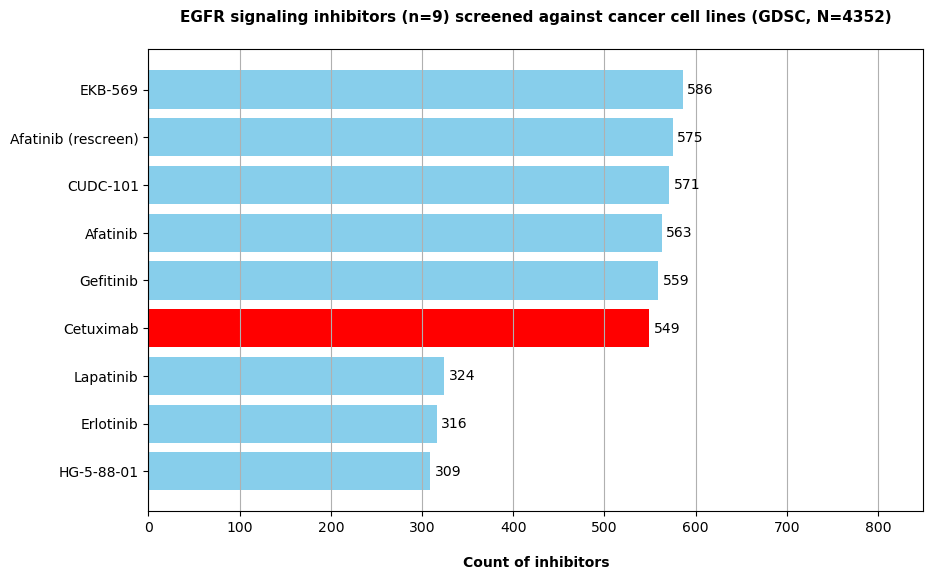

In [13]:
# plot EGFR signaling inhibitors with their counts

gdsc_drugs = dict(GDSCR["drug"].value_counts())
gdsc_drugs = dict(sorted(gdsc_drugs.items(), key=lambda item: item[1], reverse=False))
drug_names = list(gdsc_drugs.keys())
drug_values = list(gdsc_drugs.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(drug_names, drug_values, color='skyblue')

for bar, value in zip(bars, drug_values):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')
    
bars = []

for name, value in zip(drug_names, drug_values):
    if name == "Cetuximab":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))
plt.xlabel('Count of inhibitors', fontweight='bold', labelpad=15)
plt.title(f'EGFR signaling inhibitors (n={len(drug_names)}) screened against cancer cell lines (GDSC, N={sum(drug_values)})',
          fontweight='bold',
          fontsize=11,
          pad=20)
plt.xlim(0, 850)  
plt.grid(axis='x')
os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + 'EGFR Signaling Inhibitors with Their Counts (GDSC, Cetuximab).png', format='png', bbox_inches='tight')

plt.show()

In [14]:
# change directory to read PDX and TCGA expression datasets homogenized with GDSC expression dataset (Cetuximab)

os.chdir(dataset_dir + "/exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [15]:
# read PDX expression dataset homogenized with GDSC expression dataset (Cetuximab)

PDXEcetuximab = pd.read_csv("PDX_exprs.Cetuximab.eb_with.GDSC_exprs.Cetuximab.tsv",
                   sep = "\t", index_col=0, decimal = ",")
PDXEcetuximab = pd.DataFrame.transpose(PDXEcetuximab)
PDXEcetuximab.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100507206,100507254,100507436,100507472,100526773,100527978,100532746,100820829,102724473,105375355
X-1027,3.60061063639454,3.07817969365007,6.32765157689639,2.93005596217687,2.64304491832882,2.56618657438719,8.09168714940745,2.55483284192774,8.59989127217117,2.80664192172726,...,2.5997416042245,3.06591431154376,5.50994883395808,2.93037262394265,2.93460472043208,2.44987572619243,2.48989773232543,3.88458609037183,3.95227909263729,2.46055443755884
X-1119,3.54613916595946,3.07817969365007,7.46956729139981,4.20521626673769,2.929569339555,5.57576806896234,8.20319464923893,2.41443776874882,7.7754694329959,3.34200309260696,...,2.67274979347372,3.11395605082,8.98094314882696,2.93037262394265,2.93460472043208,2.44987572619243,2.48989773232543,4.81457724903364,3.95227909263729,2.84309989182372
X-1156,6.99909567844156,8.47130432034951,6.15135176832441,2.36952374925443,3.6713478754664,2.53437362934482,8.43809032488933,2.53376073162296,7.11948011162002,3.28816715734563,...,2.72150643954151,3.17396413482904,6.58328775150283,2.93037262394265,2.93460472043208,2.44987572619243,2.48989773232543,4.74727922278015,4.15062701412473,2.46987656241725


In [16]:
# read TCGA expression dataset homogenized with GDSC expression dataset (Cetuximab)

TCGAEcetuximab = pd.read_csv("TCGA_exprs.Cetuximab.eb_with.GDSC_exprs.Cetuximab.tsv",
                   sep = "\t", index_col=0, decimal = ",")
TCGAEcetuximab = pd.DataFrame.transpose(TCGAEcetuximab)
TCGAEcetuximab.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100188893,100190940,100190949,100191040,100192386,100268168,100271715,100287718,100288778,100289635
TCGA-BA-A4IG-01A,3.53364972782538,2.63169744477874,6.46913538384915,3.11954321356217,1.78425710174861,4.78953909500701,8.06446753523746,3.04479803527151,9.18974247446462,2.91775104542515,...,9.88694622925868,3.1254895591217,0,3.5074580817852,3.01824927947277,2.84422970206547,3.5035589781396,3.06737618948643,4.01010719689955,4.66295551081748
TCGA-CN-4731-01A,4.12585378817146,2.1506582678597,6.44489273685529,3.21409376420109,3.15286503399873,3.28492483066951,8.22062958425597,2.67285528315238,8.51873835886811,5.1735664410497,...,9.26858559890324,3.08733295866026,0,3.30585011523952,3.3487497141691,2.6930439585389,2.45792584512192,2.99299508958328,3.94714478968898,4.17054508896713
TCGA-CN-A49C-01A,4.37925369978313,3.43283585192836,6.59346803138021,3.11954321356217,3.31289809486857,3.10283527665291,8.2759744669096,2.74770994492163,8.98377132955025,3.96878580867183,...,9.71555609970402,3.0546486734275,0,3.67110924364761,3.04644627367641,2.61249547417883,3.00945260505516,3.06200290033863,5.05997145230091,4.13533467313432


In [17]:
# change directory to read PDX mutation dataset (Cetuximab)

os.chdir(dataset_dir + "mutations")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations'

In [18]:
# read PDX mutation dataset (Cetuximab)

PDXMcetuximab = pd.read_csv("PDX_mutations.Cetuximab.tsv",
                        sep="\t", index_col=0, decimal=",")
PDXMcetuximab.drop_duplicates(keep='last')
PDXMcetuximab = pd.DataFrame.transpose(PDXMcetuximab)
PDXMcetuximab = PDXMcetuximab.loc[:, ~PDXMcetuximab.columns.duplicated()]

PDXMcetuximab.head(3)

ENTREZID,3075.0,171017.0,2058.0,79890.0,7701.0,3104.0,4642.0,9778.0,100132406.0,23607.0,...,253738.0,154807.0,79140.0,6307.0,6352.0,56005.0,115650.0,64946.0,5777.0,253639.0
X-1027,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1119,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,0.0,-0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1156,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,-0.05,-0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# read TCGA mutation dataset (Cetuximab)

TCGAMcetuximab = pd.read_csv("TCGA_mutations.Cetuximab.tsv",
                        sep="\t", index_col=0, decimal=",")
TCGAMcetuximab.drop_duplicates(keep='last')
TCGAMcetuximab = pd.DataFrame.transpose(TCGAMcetuximab)
TCGAMcetuximab = TCGAMcetuximab.loc[:, ~TCGAMcetuximab.columns.duplicated()]

TCGAMcetuximab.head(3)

,27136,84993,56834,10256,6672,253461,90134,162333,345630,10278,...,374395,23173,646498,23016,10888,8347,29901,9445,766,2944
TCGA-BA-A4IG-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-CN-4731-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-CN-A49C-01A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# variance threshold for GDSC expression dataset (EGFRi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [21]:
# fill NA values and binarize GDSC mutation dataset (EGFRi)

GDSCM = GDSCM.fillna(0)
GDSCM[GDSCM != 0.0] = 1

In [22]:
# select shared genes between GDSC, PDX, and TCGA expression and mutation datasets 

ls = GDSCE.columns.intersection(GDSCM.columns)
ls = ls.intersection(PDXEcetuximab.columns)
ls = ls.intersection(PDXMcetuximab.columns)
ls = ls.intersection(TCGAEcetuximab.columns)
ls = ls.intersection(TCGAMcetuximab.columns)

ls = pd.unique(ls)

print(f"GDSC, PDX & TCGA # of common genes: {ls.shape[0]}")

GDSC, PDX & TCGA # of common genes: 12203


In [23]:
# select shared samples between GDSC expression, mutation, and response datasets (EGFRi)

ls2 = GDSCE.index.intersection(GDSCM.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 611


In [24]:
# subset shared genes and samples in GDSC expression, mutation, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCM = GDSCM.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCM.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

GDSC # of common samples and genes (Expression): (611, 12203)
GDSC # of common samples and genes (Mutation): (611, 12203)
GDSC # of samples (Response): 4352


In [25]:
# select shared samples between PDX expression and mutation datasets (Cetuximab) 

ls3 = PDXEcetuximab.index.intersection(PDXMcetuximab.index)

print(f"PDX # of common samples (Cetuximab): {ls3.shape[0]}")

PDX # of common samples (Cetuximab): 60


In [26]:
# select shared samples between TCGA expression and mutation datasets (Cetuximab) 

ls4 = TCGAEcetuximab.index.intersection(TCGAMcetuximab.index)

print(f"TCGA # of common samples (Cetuximab): {ls4.shape[0]}")

TCGA # of common samples (Cetuximab): 9


In [27]:
# select shared genes and samples between PDX and TCGA expression and mutation datasets (Cetuximab)

PDXEcetuximab = PDXEcetuximab.loc[ls3, ls]
PDXMcetuximab = PDXMcetuximab.loc[ls3, ls]

TCGAEcetuximab = TCGAEcetuximab.loc[ls4, ls]
TCGAMcetuximab = TCGAMcetuximab.loc[ls4, ls]

print(f"PDX # of common samples and genes for Expression (Cetuximab): {PDXEcetuximab.shape}")
print(f"PDX # of common samples and genes for Mutation (Cetuximab): {PDXMcetuximab.shape}\n")

print(f"TCGA # of common samples and genes for Expression (Cetuximab): {TCGAEcetuximab.shape}")
print(f"TCGA # of common samples and genes for Mutation (Cetuximab): {TCGAMcetuximab.shape}")

PDX # of common samples and genes for Expression (Cetuximab): (60, 12203)
PDX # of common samples and genes for Mutation (Cetuximab): (60, 12203)

TCGA # of common samples and genes for Expression (Cetuximab): (9, 12203)
TCGA # of common samples and genes for Mutation (Cetuximab): (9, 12203)


In [28]:
# change directory to read DEGs (EGFRi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/EGFRi


In [29]:
# read DEGs (EGFRi)

DEGs_filtered_data = pd.read_excel("EGFRi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05 and |logFC| > 1) among EGFR signaling inhibitors\n")

DEGs_filtered_data.head()

There are 1028 DEGs (p-adjusted < 0.05 and |logFC| > 1) among EGFR signaling inhibitors



,Gene Symbol,Frequency
0,MYOF,9
1,TM4SF1,8
2,KRT18,8
3,WWC1,8
4,CAV1,8


In [30]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id = pd.unique(DEGs_entrez_id.dropna())
DEGs_entrez_id = pd.Series(DEGs_entrez_id)

result = mg.query("SLC22A18", species="human", scopes="symbol", fields="entrezgene")
DEGs_entrez_id = pd.concat([DEGs_entrez_id, pd.Series(str(result["hits"][1]["entrezgene"]))], ignore_index=True)

DEGs_entrez_id.shape[0]

2 input query terms found dup hits:	[('CLECL1P', 2), ('CAST', 2)]
1 input query terms found no hit:	['SLC22A18']


1028

In [31]:
# assign GDSC datasets to new variables

exprs_z = GDSCE
mut = GDSCM
responses = GDSCR

In [32]:
# GDSC response dataset

responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
910688,0,1.24811569418395,Afatinib,1,1,1
910688,0,3.82039284182925,Afatinib (rescreen),1,1,1
910688,0,6.01825066230241,Cetuximab,1,1,1


In [33]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'Afatinib',
 'Afatinib (rescreen)',
 'CUDC-101',
 'Cetuximab',
 'EKB-569',
 'Erlotinib',
 'Gefitinib',
 'HG-5-88-01',
 'Lapatinib'}

In [34]:
# convert Entrez gene IDs to string

GDSCE.index = GDSCE.index.astype(str)
GDSCM.index = GDSCM.index.astype(str)
responses.index = responses.index.astype(str)

In [35]:
# merge GDSC cell line details with response dataset

dat = pd.merge(GDSC_cell_line_details,
         responses,
         left_index = True, 
         right_index=True,
         how = "inner")

dat["GDSC\nTissue descriptor 1"].value_counts()
#dat.head()

GDSC\nTissue descriptor 1
leukemia             538
urogenital_system    531
lymphoma             487
nervous_system       369
lung_SCLC            347
skin                 334
breast               299
digestive_system     268
bone                 261
neuroblastoma        212
pancreas             154
kidney               138
myeloma              113
soft_tissue          112
lung                  99
thyroid               90
Name: count, dtype: int64

In [36]:
# get tissue descriptors

dat["GDSC\nTissue\ndescriptor 2"].value_counts().head()

GDSC\nTissue\ndescriptor 2
lung_small_cell_carcinoma    347
glioma                       341
melanoma                     311
breast                       299
B_cell_lymphoma              218
Name: count, dtype: int64

In [37]:
# assign tissue descriptors to variable

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_names

['leukemia',
 'urogenital_system',
 'lymphoma',
 'nervous_system',
 'lung_SCLC',
 'skin',
 'breast',
 'digestive_system',
 'bone',
 'neuroblastoma',
 'pancreas',
 'kidney',
 'myeloma',
 'soft_tissue',
 'lung',
 'thyroid']

In [38]:
# list count of cell lines as to tissues treated with cetuximab

filter = (dat["drug"] == "Cetuximab")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

GDSC\nTissue descriptor 1
urogenital_system    76
leukemia             66
lymphoma             56
nervous_system       47
skin                 44
breast               41
lung_SCLC            39
digestive_system     37
bone                 34
pancreas             20
kidney               19
neuroblastoma        19
soft_tissue          16
myeloma              13
lung                 11
thyroid              11
Name: count, dtype: int64

In [39]:
# list count of cell lines as to tissues treated with cetuximab

tissues_drugs = dat[["GDSC\nTissue descriptor 1","GDSC\nTissue\ndescriptor 2","drug"]]

filter = (tissues_drugs["drug"] == "Cetuximab")
tissues_drug = tissues_drugs.loc[filter,"GDSC\nTissue\ndescriptor 2"].value_counts()

tissues_drug.head()

GDSC\nTissue\ndescriptor 2
glioma                       44
breast                       41
melanoma                     41
lung_small_cell_carcinoma    39
ovary                        26
Name: count, dtype: int64

In [40]:
# filter GDSC expression and mutation datasets (EGFRi) as to drugs
# subset selected DEGs

expression_zscores = []
mutations = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    m = mut.loc[samples, :]
    expression_zscores.append(e_z)
    mutations.append(m)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCMv2 = pd.concat(mutations, axis=0)
GDSCRv2 = responses

ls5 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls6 = GDSCEv2.index.intersection(GDSCMv2.index)

GDSCEv2 = GDSCEv2.loc[ls6, ls5]
GDSCMv2 = GDSCMv2.loc[ls6, ls5]
GDSCRv2 = GDSCRv2.loc[ls6, :]

PDXEcetuximab = PDXEcetuximab.loc[:,ls5]
PDXMcetuximab = PDXMcetuximab.loc[:,ls5]
TCGAEcetuximab = TCGAEcetuximab.loc[:,ls5]
TCGAMcetuximab = TCGAMcetuximab.loc[:,ls5]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCMv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for Cetuximab (Expression): {PDXEcetuximab.shape}")
print(f"PDX # of common samples and genes for Cetuximab (Mutation): {PDXMcetuximab.shape}\n")

print(f"TCGA # of common samples and genes for Cetuximab (Expression): {TCGAEcetuximab.shape}")
print(f"TCGA # of common samples and genes for Cetuximab (Mutation): {TCGAMcetuximab.shape}")

GDSC # of common samples and genes (Expression): (4352, 751)
GDSC # of common samples and genes (Mutation): (4352, 751)
GDSC # of common samples (Response): 4352

PDX # of common samples and genes for Cetuximab (Expression): (60, 751)
PDX # of common samples and genes for Cetuximab (Mutation): (60, 751)

TCGA # of common samples and genes for Cetuximab (Expression): (9, 751)
TCGA # of common samples and genes for Cetuximab (Mutation): (9, 751)


In [41]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 0 ... 1 0 0]


In [42]:
# change directory to read PDX and TCGA response datasets (Cetuximab)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [43]:
# read PDX response dataset (Cetuximab)

PDXRcetuximab = pd.read_csv("PDX_response.Cetuximab.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
PDXRcetuximab.dropna(inplace=True)
PDXRcetuximab.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
PDXRcetuximab["response"] = PDXRcetuximab.loc[:, "response"].apply(lambda x: d[x])
Ytscetuximab_pdx = PDXRcetuximab["response"].values    

print(f"There are {Ytscetuximab_pdx.shape[0]} samples with response data in the PDX (Cetuximab)\n")
Ytscetuximab_pdx

There are 60 samples with response data in the PDX (Cetuximab)



array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [44]:
# read PDX dataset to select cohorts (Cetuximab)

pdx_cohort = pd.read_excel(pdx_data_dir + "/nm.3954-S2.xlsx",
                              "PCT raw data")
pdx_cohort = pdx_cohort.loc[pdx_cohort["Treatment"] == "cetuximab",]
pdx_cohort = pdx_cohort.loc[:,["Model","Tumor Type"]]
pdx_cohort = pdx_cohort.drop_duplicates()
pdx_cohort.set_index("Model", inplace = True) 
pdx_cohort.head()

,Tumor Type
Model,
X-0933,CRC
X-1027,CRC
X-1055,CRC
X-1119,CRC
X-1156,NSCLC


In [45]:
# merged PDX cohort table with PDX response dataset (Cetuximab)

dat_pdx = pd.merge(pdx_cohort,
                   PDXRcetuximab,
                   left_index = True,
                   right_index = True)
dat_pdx["Tumor Type"].value_counts()

Tumor Type
CRC      36
NSCLC    24
Name: count, dtype: int64

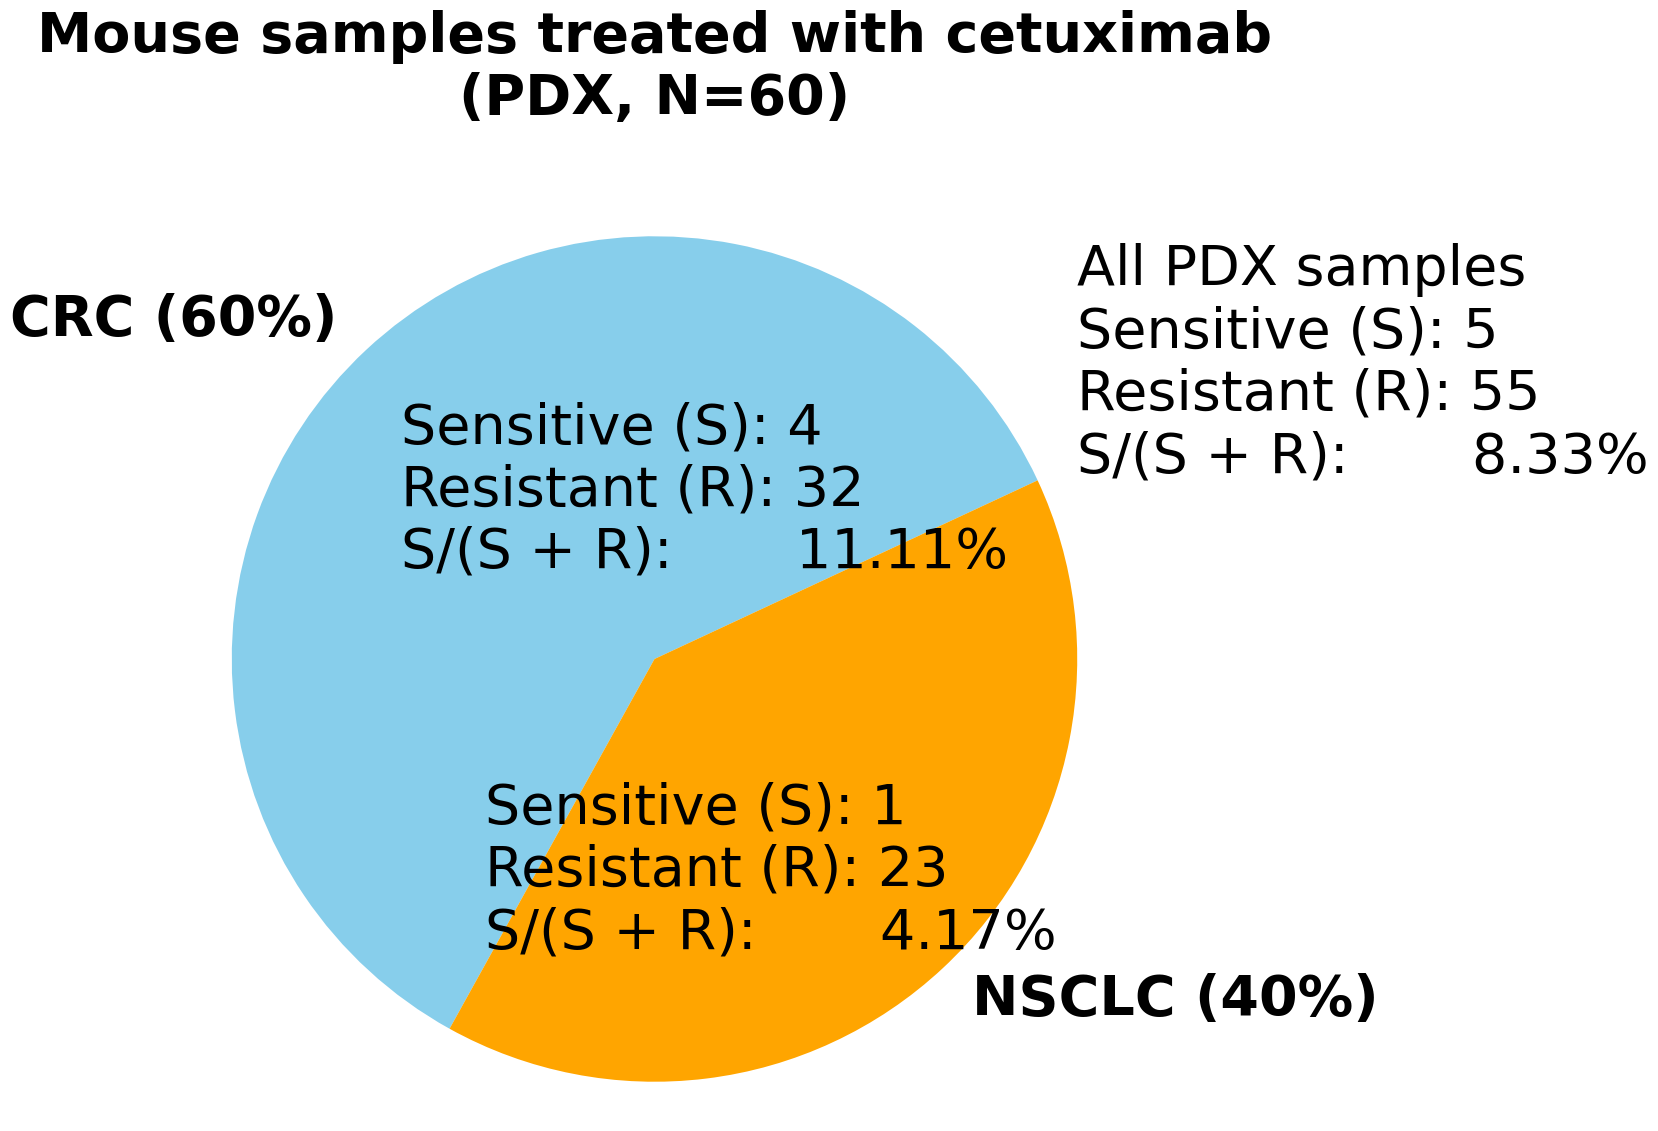

In [46]:
# plot tissue types of PDX samples 

labels = list(dat_pdx["Tumor Type"].value_counts().index)
sizes = list(dat_pdx["Tumor Type"].value_counts().astype(int))
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

# Assign the plot to variable fig_D
fig_D = plt.figure(figsize=(12, 12))
plt.pie(sizes, labels=labels_with_percentages, startangle=25, colors=['skyblue', 'orange'], textprops={'fontsize': 40, 'fontweight': 'bold'})
plt.title(f'Mouse samples treated with cetuximab\n(PDX, N={total})\n', fontweight="bold", pad=15, fontsize=40, loc="center")
plt.axis('equal')

plt.text(-0.6, 0.4, 
         f'Sensitive (S): {dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]} \nResistant (R): {dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]/(sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts())) * 100, 2)}%', 
         fontsize=40, 
         color='black',
         va='center')

plt.text(-0.4, -0.5, 
         f'Sensitive (S): {dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(1, 0)} \nResistant (R): {dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(1, 0)/(sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts())) * 100, 2)}%', 
         fontsize=40, 
         color='black',
         va='center')

plt.text(1, 0.7, 
         f'All PDX samples\nSensitive (S): {PDXRcetuximab["response"].value_counts()[1]} \nResistant (R): {PDXRcetuximab["response"].value_counts().get(0, 0)} \nS/(S + R):       {round(PDXRcetuximab["response"].value_counts()[1]/(sum(PDXRcetuximab["response"].value_counts())) * 100, 2)}%', 
         fontsize=40, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of PDX samples (cetuximab).png', format='png', bbox_inches='tight')

plt.show()

In [47]:
# filter CRC cohort samples (Cetuximab)

filter = (dat_pdx["Tumor Type"] == "CRC")
pdx_crc_samples = dat_pdx.loc[filter,].index
pdx_crc_samples

Index(['X-1027', 'X-1119', 'X-1167', 'X-1173', 'X-1270', 'X-1290', 'X-1303',
       'X-1329', 'X-1443', 'X-1479', 'X-1500', 'X-1536', 'X-1538', 'X-2145',
       'X-2182', 'X-2239', 'X-2403', 'X-2483', 'X-2484', 'X-2538', 'X-2573',
       'X-2659', 'X-2822', 'X-2846', 'X-2861', 'X-3093', 'X-3205', 'X-3224',
       'X-3671', 'X-3792', 'X-4087', 'X-5254', 'X-5405', 'X-5446', 'X-5495',
       'X-5578'],
      dtype='object')

In [48]:
# filter responses of CRC cohort samples (Cetuximab)

Ytscetuximab_pdx_crc = PDXRcetuximab.loc[pdx_crc_samples,"response"].values
Ytscetuximab_pdx_crc

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [49]:
# count of sensitive and resistant CRC samples (Cetuximab)

PDXRcetuximab.loc[pdx_crc_samples,"response"].value_counts()

response
0    32
1     4
Name: count, dtype: int64

In [50]:
# filter NSCLC cohort samples (Cetuximab)

filter = (dat_pdx["Tumor Type"] == "NSCLC")
pdx_nsclc_samples = dat_pdx.loc[filter,].index
pdx_nsclc_samples

Index(['X-1156', 'X-1172', 'X-1323', 'X-1442', 'X-1499', 'X-1586', 'X-1658',
       'X-1725', 'X-1787', 'X-1823', 'X-1834', 'X-1835', 'X-1934', 'X-1980',
       'X-1993', 'X-2017', 'X-2042', 'X-2082', 'X-2088', 'X-2094', 'X-3029',
       'X-3237', 'X-3843', 'X-4819'],
      dtype='object')

In [51]:
# filter responses of NSCLC cohort samples (Cetuximab)

Ytscetuximab_pdx_nsclc = PDXRcetuximab.loc[pdx_nsclc_samples,"response"].values
Ytscetuximab_pdx_nsclc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0])

In [52]:
# count of sensitive and resistant NSCLC samples (Cetuximab)

PDXRcetuximab.loc[pdx_nsclc_samples,"response"].value_counts()

response
0    23
1     1
Name: count, dtype: int64

In [53]:
# read TCGA response dataset (Cetuximab)

TCGARcetuximab = pd.read_csv("TCGA_response.Cetuximab.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
TCGARcetuximab.dropna(inplace=True)
TCGARcetuximab.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
TCGARcetuximab["response"] = TCGARcetuximab.loc[:, "response"].apply(lambda x: d[x])
Ytscetuximab_tcga = TCGARcetuximab["response"].values    

print(f"There are {Ytscetuximab_tcga.shape[0]} samples with response data in the TCGA (Cetuximab)\n")
Ytscetuximab_tcga

There are 9 samples with response data in the TCGA (Cetuximab)



array([1, 0, 1, 1, 1, 1, 0, 0, 1])

In [54]:
# TCGA cohort table with TCGA response dataset (Cetuximab)

dat_tcga = TCGARcetuximab["cohort"]

dat_tcga.value_counts()

cohort
HNSC    9
Name: count, dtype: int64

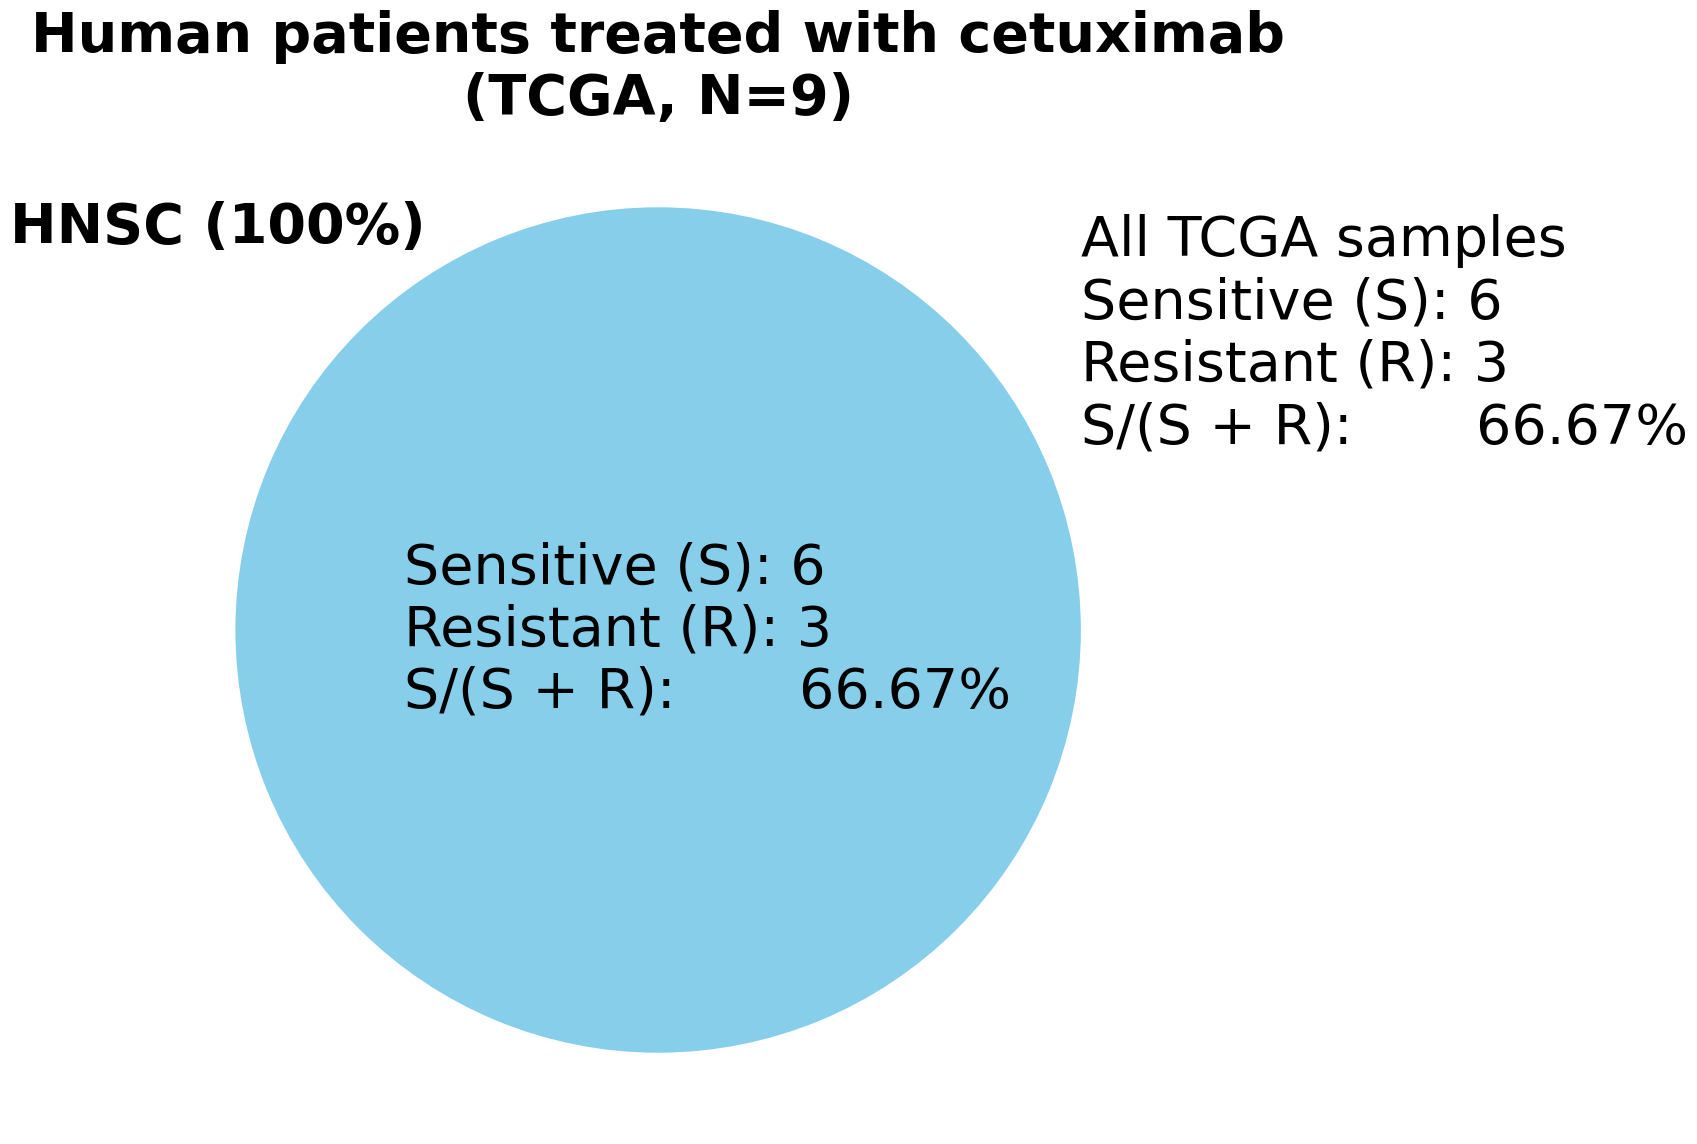

In [55]:
# plot tissue types of TCGA samples 

labels = list(dat_tcga.value_counts().index)
sizes = list(dat_tcga.value_counts())
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

# Assign the plot to variable fig_E
fig_E = plt.figure(figsize=(12, 12))
plt.pie(sizes, labels=labels_with_percentages, startangle=-60, colors=['skyblue', 'lightgreen', 'salmon', 'orange','pink'], textprops={'fontsize': 40, 'fontweight': 'bold'})
plt.title(f'Human patients treated with cetuximab\n(TCGA, N={total})', fontweight = "bold", fontsize = 40 )
plt.subplots_adjust(top=0.95) 
plt.axis('equal')  

plt.text(-0.6, 0, 
         f'Sensitive (S): {TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]} \nResistant (R): {TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[0]} \nS/(S + R):       {round(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]/(sum(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts())) * 100, 2)}%', 
         fontsize=40, 
         color='black',
         va='center')

plt.text(1, 0.7, 
         f'All TCGA samples\nSensitive (S): {TCGARcetuximab["response"].value_counts()[1]} \nResistant (R): {TCGARcetuximab["response"].value_counts().get(0, 0)} \nS/(S + R):       {round(TCGARcetuximab["response"].value_counts()[1]/(sum(TCGARcetuximab["response"].value_counts())) * 100, 2)}%', 
         fontsize=40, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of TCGA samples (cetuximab).png', format='png', bbox_inches='tight')

plt.show()

In [56]:
# filter HNSC cohort samples (Cetuximab)

filter = (TCGARcetuximab["cohort"] == "HNSC")
tcga_hnsc_samples = dat_tcga.loc[filter,].index
tcga_hnsc_samples

Index(['TCGA-BA-A4IG-01A', 'TCGA-CN-4731-01A', 'TCGA-CN-A49C-01A',
       'TCGA-CN-A6V1-01A', 'TCGA-CR-7404-01A', 'TCGA-DQ-7596-01A',
       'TCGA-HD-8224-01A', 'TCGA-KU-A6H8-01A', 'TCGA-RS-A6TO-01A'],
      dtype='object', name='sample')

In [57]:
# filter responses of HNSC cohort samples (Cetuximab)

Ytscetuximab_tcga_hnsc = TCGARcetuximab.loc[tcga_hnsc_samples,"response"].values
Ytscetuximab_tcga_hnsc

array([1, 0, 1, 1, 1, 1, 0, 0, 1])

In [58]:
# count of sensitive and resistance HNSC samples (Cetuximab)

TCGARcetuximab.loc[tcga_hnsc_samples,"response"].value_counts()

response
1    6
0    3
Name: count, dtype: int64

In [59]:
# maximum iteration

max_iter = 50

In [60]:
# use count of nodes and dropout rates found in trained pan-drug dataset

hdm1 = 256
hdm2 = 64
rate1 = 0.8
rate2 = 0.4
rate3 = 0.8

In [61]:
# load pre-trained modules and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEcetuximab_pdx = scalerGDSC.transform(PDXEcetuximab.values) 
X_testEcetuximab_pdx_crc = scalerGDSC.transform(PDXEcetuximab.loc[pdx_crc_samples,].values) 
X_testEcetuximab_pdx_nsclc = scalerGDSC.transform(PDXEcetuximab.loc[pdx_nsclc_samples,].values) 

X_testEcetuximab_tcga = scalerGDSC.transform(TCGAEcetuximab.values)    
X_testEcetuximab_tcga_hnsc = scalerGDSC.transform(TCGAEcetuximab.loc[tcga_hnsc_samples,].values)    

X_trainM = np.nan_to_num(GDSCMv2.values)
X_testMcetuximab_pdx = np.nan_to_num(PDXMcetuximab.values.astype(np.float32))
X_testMcetuximab_pdx_crc = np.nan_to_num(PDXMcetuximab.loc[pdx_crc_samples,].values.astype(np.float32))
X_testMcetuximab_pdx_nsclc = np.nan_to_num(PDXMcetuximab.loc[pdx_nsclc_samples,].values.astype(np.float32))
X_testMcetuximab_tcga = np.nan_to_num(TCGAMcetuximab.values.astype(np.float32))
X_testMcetuximab_tcga_hnsc = np.nan_to_num(TCGAMcetuximab.loc[tcga_hnsc_samples,].values.astype(np.float32))

TX_testEcetuximab_pdx = torch.FloatTensor(X_testEcetuximab_pdx)
TX_testEcetuximab_pdx_crc = torch.FloatTensor(X_testEcetuximab_pdx_crc)
TX_testEcetuximab_pdx_nsclc = torch.FloatTensor(X_testEcetuximab_pdx_nsclc)

TX_testMcetuximab_pdx = torch.FloatTensor(X_testMcetuximab_pdx.astype(np.float32))
TX_testMcetuximab_pdx_crc = torch.FloatTensor(X_testMcetuximab_pdx_crc.astype(np.float32))
TX_testMcetuximab_pdx_nsclc = torch.FloatTensor(X_testMcetuximab_pdx_nsclc.astype(np.float32))

ty_testEcetuximab_pdx = torch.FloatTensor(Ytscetuximab_pdx.astype(int))
ty_testEcetuximab_pdx_crc = torch.FloatTensor(Ytscetuximab_pdx_crc.astype(int))
ty_testEcetuximab_pdx_nsclc = torch.FloatTensor(Ytscetuximab_pdx_nsclc.astype(int))

TX_testEcetuximab_tcga = torch.FloatTensor(X_testEcetuximab_tcga)
TX_testEcetuximab_tcga_hnsc = torch.FloatTensor(X_testEcetuximab_tcga_hnsc)

TX_testMcetuximab_tcga = torch.FloatTensor(X_testMcetuximab_tcga.astype(np.float32))
TX_testMcetuximab_tcga_hnsc = torch.FloatTensor(X_testMcetuximab_tcga_hnsc.astype(np.float32))

ty_testEcetuximab_tcga = torch.FloatTensor(Ytscetuximab_tcga.astype(int))
ty_testEcetuximab_tcga_hnsc = torch.FloatTensor(Ytscetuximab_tcga_hnsc.astype(int))

n_sampE, IE_dim = X_trainE.shape
n_sampM, IM_dim = X_trainM.shape

h_dim1 = hdm1
h_dim2 = hdm2
Z_in = h_dim1 + h_dim2

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output  


class AEM(nn.Module):
    def __init__(self):
        super(AEM, self).__init__()
        self.EnM = torch.nn.Sequential(
            nn.Linear(IM_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnM(x)
        return output       
        
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate3),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy.pt")
AutoencoderM = torch.load(models_dir + "Mut_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy.pt")

Clas = torch.load(models_dir + "Class_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy.pt")

AutoencoderE.eval()
AutoencoderM.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZMX = AutoencoderM(torch.FloatTensor(X_trainM))
ZTX = torch.cat((ZEX, ZMX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())

ZETcetuximab_pdx = AutoencoderE(TX_testEcetuximab_pdx)
ZMTcetuximab_pdx = AutoencoderM(TX_testMcetuximab_pdx)
ZTTcetuximab_pdx = torch.cat((ZETcetuximab_pdx, ZMTcetuximab_pdx), 1)
ZTTcetuximab_pdx = F.normalize(ZTTcetuximab_pdx, p=2, dim=0)
PredTcetuximab_pdx = Clas(ZTTcetuximab_pdx)
AUCTcetuximab_pdx = roc_auc_score(Ytscetuximab_pdx.astype(int), PredTcetuximab_pdx.detach().numpy())
AUCTcetuximab_pdx_aucpr = average_precision_score(Ytscetuximab_pdx.astype(int), PredTcetuximab_pdx.detach().numpy())

ZETcetuximab_pdx_crc = AutoencoderE(TX_testEcetuximab_pdx_crc)
ZMTcetuximab_pdx_crc = AutoencoderM(TX_testMcetuximab_pdx_crc)
ZTTcetuximab_pdx_crc = torch.cat((ZETcetuximab_pdx_crc, ZMTcetuximab_pdx_crc), 1)
ZTTcetuximab_pdx_crc = F.normalize(ZTTcetuximab_pdx_crc, p=2, dim=0)
PredTcetuximab_pdx_crc = Clas(ZTTcetuximab_pdx_crc)
AUCTcetuximab_pdx_crc = roc_auc_score(Ytscetuximab_pdx_crc.astype(int), PredTcetuximab_pdx_crc.detach().numpy())
AUCTcetuximab_pdx_crc_aucpr = average_precision_score(Ytscetuximab_pdx_crc.astype(int), PredTcetuximab_pdx_crc.detach().numpy())

ZETcetuximab_pdx_nsclc = AutoencoderE(TX_testEcetuximab_pdx_nsclc)
ZMTcetuximab_pdx_nsclc = AutoencoderM(TX_testMcetuximab_pdx_nsclc)
ZTTcetuximab_pdx_nsclc = torch.cat((ZETcetuximab_pdx_nsclc, ZMTcetuximab_pdx_nsclc), 1)
ZTTcetuximab_pdx_nsclc = F.normalize(ZTTcetuximab_pdx_nsclc, p=2, dim=0)
PredTcetuximab_pdx_nsclc = Clas(ZTTcetuximab_pdx_nsclc)
AUCTcetuximab_pdx_nsclc = roc_auc_score(Ytscetuximab_pdx_nsclc.astype(int), PredTcetuximab_pdx_nsclc.detach().numpy())
AUCTcetuximab_pdx_nsclc_aucpr = average_precision_score(Ytscetuximab_pdx_nsclc.astype(int), PredTcetuximab_pdx_nsclc.detach().numpy())

ZETcetuximab_tcga = AutoencoderE(TX_testEcetuximab_tcga)
ZMTcetuximab_tcga = AutoencoderM(TX_testMcetuximab_tcga)
ZTTcetuximab_tcga = torch.cat((ZETcetuximab_tcga, ZMTcetuximab_tcga), 1)
ZTTcetuximab_tcga = F.normalize(ZTTcetuximab_tcga, p=2, dim=0)
PredTcetuximab_tcga = Clas(ZTTcetuximab_tcga)
AUCTcetuximab_tcga = roc_auc_score(Ytscetuximab_tcga.astype(int), PredTcetuximab_tcga.detach().numpy())
AUCTcetuximab_tcga_aucpr = average_precision_score(Ytscetuximab_tcga.astype(int), PredTcetuximab_tcga.detach().numpy())

ZETcetuximab_tcga_hnsc = AutoencoderE(TX_testEcetuximab_tcga_hnsc)
ZMTcetuximab_tcga_hnsc = AutoencoderM(TX_testMcetuximab_tcga_hnsc)
ZTTcetuximab_tcga_hnsc = torch.cat((ZETcetuximab_tcga_hnsc, ZMTcetuximab_tcga_hnsc), 1)
ZTTcetuximab_tcga_hnsc = F.normalize(ZTTcetuximab_tcga_hnsc, p=2, dim=0)
PredTcetuximab_tcga_hnsc = Clas(ZTTcetuximab_tcga_hnsc)
AUCTcetuximab_tcga_hnsc = roc_auc_score(Ytscetuximab_tcga_hnsc.astype(int), PredTcetuximab_tcga_hnsc.detach().numpy())
AUCTcetuximab_tcga_hnsc_aucpr = average_precision_score(Ytscetuximab_tcga_hnsc.astype(int), PredTcetuximab_tcga_hnsc.detach().numpy())

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTcetuximab_pdx_finetuned = dict()
AUCTcetuximab_tcga_finetuned = dict()
AUCTcetuximab_pdx_crc_finetuned = dict()
AUCTcetuximab_pdx_nsclc_finetuned = dict()
AUCTcetuximab_tcga_hnsc_finetuned = dict()
AUCTcetuximab_pdx_aucpr_finetuned = dict()
AUCTcetuximab_tcga_aucpr_finetuned = dict()
AUCTcetuximab_pdx_crc_aucpr_finetuned = dict()
AUCTcetuximab_pdx_nsclc_aucpr_finetuned = dict()
AUCTcetuximab_tcga_hnsc_aucpr_finetuned = dict()
for iter in range(max_iter):
   iter += 1  

   AutoencoderE_finetuned = torch.load(finetuned_dir + f"Exprs_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{iter}.pt")
   AutoencoderM_finetuned = torch.load(finetuned_dir + f"Mut_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{iter}.pt")
   Clas_finetuned = torch.load(finetuned_dir + f"Class_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{iter}.pt")
   
   AutoencoderE_finetuned.eval()
   AutoencoderM_finetuned.eval()
   Clas_finetuned.eval()
      
   ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
   ZMX = AutoencoderM_finetuned(torch.FloatTensor(X_trainM))
   ZTX = torch.cat((ZEX, ZMX), 1)
   ZTX = F.normalize(ZTX, p=2, dim=0)
   PredX = Clas_finetuned(ZTX)
   AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
   AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
   ZETcetuximab_pdx = AutoencoderE_finetuned(TX_testEcetuximab_pdx)
   ZMTcetuximab_pdx = AutoencoderM_finetuned(TX_testMcetuximab_pdx)
   ZTTcetuximab_pdx = torch.cat((ZETcetuximab_pdx, ZMTcetuximab_pdx), 1)
   ZTTcetuximab_pdx = F.normalize(ZTTcetuximab_pdx, p=2, dim=0)
   PredTcetuximab_pdx = Clas_finetuned(ZTTcetuximab_pdx)
   AUCTcetuximab_pdx_finetuned[iter] = roc_auc_score(Ytscetuximab_pdx.astype(int), PredTcetuximab_pdx.detach().numpy())
   AUCTcetuximab_pdx_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab_pdx.astype(int), PredTcetuximab_pdx.detach().numpy())

   ZETcetuximab_pdx_crc = AutoencoderE_finetuned(TX_testEcetuximab_pdx_crc)
   ZMTcetuximab_pdx_crc = AutoencoderM_finetuned(TX_testMcetuximab_pdx_crc)
   ZTTcetuximab_pdx_crc = torch.cat((ZETcetuximab_pdx_crc, ZMTcetuximab_pdx_crc), 1)
   ZTTcetuximab_pdx_crc = F.normalize(ZTTcetuximab_pdx_crc, p=2, dim=0)
   PredTcetuximab_pdx_crc = Clas_finetuned(ZTTcetuximab_pdx_crc)
   AUCTcetuximab_pdx_crc_finetuned[iter] = roc_auc_score(Ytscetuximab_pdx_crc.astype(int), PredTcetuximab_pdx_crc.detach().numpy())
   AUCTcetuximab_pdx_crc_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab_pdx_crc.astype(int), PredTcetuximab_pdx_crc.detach().numpy())

   ZETcetuximab_pdx_nsclc = AutoencoderE_finetuned(TX_testEcetuximab_pdx_nsclc)
   ZMTcetuximab_pdx_nsclc = AutoencoderM_finetuned(TX_testMcetuximab_pdx_nsclc)
   ZTTcetuximab_pdx_nsclc = torch.cat((ZETcetuximab_pdx_nsclc, ZMTcetuximab_pdx_nsclc), 1)
   ZTTcetuximab_pdx_nsclc = F.normalize(ZTTcetuximab_pdx_nsclc, p=2, dim=0)
   PredTcetuximab_pdx_nsclc = Clas_finetuned(ZTTcetuximab_pdx_nsclc)
   AUCTcetuximab_pdx_nsclc_finetuned[iter] = roc_auc_score(Ytscetuximab_pdx_nsclc.astype(int), PredTcetuximab_pdx_nsclc.detach().numpy())
   AUCTcetuximab_pdx_nsclc_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab_pdx_nsclc.astype(int), PredTcetuximab_pdx_nsclc.detach().numpy())

   ZETcetuximab_tcga = AutoencoderE_finetuned(TX_testEcetuximab_tcga)
   ZMTcetuximab_tcga = AutoencoderM_finetuned(TX_testMcetuximab_tcga)
   ZTTcetuximab_tcga = torch.cat((ZETcetuximab_tcga, ZMTcetuximab_tcga), 1)
   ZTTcetuximab_tcga = F.normalize(ZTTcetuximab_tcga, p=2, dim=0)
   PredTcetuximab_tcga = Clas_finetuned(ZTTcetuximab_tcga)
   AUCTcetuximab_tcga_finetuned[iter] = roc_auc_score(Ytscetuximab_tcga.astype(int), PredTcetuximab_tcga.detach().numpy())
   AUCTcetuximab_tcga_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab_tcga.astype(int), PredTcetuximab_tcga.detach().numpy())

   ZETcetuximab_tcga_hnsc = AutoencoderE_finetuned(TX_testEcetuximab_tcga_hnsc)
   ZMTcetuximab_tcga_hnsc = AutoencoderM_finetuned(TX_testMcetuximab_tcga_hnsc)
   ZTTcetuximab_tcga_hnsc = torch.cat((ZETcetuximab_tcga_hnsc, ZMTcetuximab_tcga_hnsc), 1)
   ZTTcetuximab_tcga_hnsc = F.normalize(ZTTcetuximab_tcga_hnsc, p=2, dim=0)
   PredTcetuximab_tcga_hnsc = Clas_finetuned(ZTTcetuximab_tcga_hnsc)
   AUCTcetuximab_tcga_hnsc_finetuned[iter] = roc_auc_score(Ytscetuximab_tcga_hnsc.astype(int), PredTcetuximab_tcga_hnsc.detach().numpy())
   AUCTcetuximab_tcga_hnsc_aucpr_finetuned[iter] = average_precision_score(Ytscetuximab_tcga_hnsc.astype(int), PredTcetuximab_tcga_hnsc.detach().numpy())

max_key_pdx = max(AUCTcetuximab_pdx_aucpr_finetuned, key=AUCTcetuximab_pdx_aucpr_finetuned.get)
max_key_pdx_crc = max(AUCTcetuximab_pdx_crc_aucpr_finetuned, key=AUCTcetuximab_pdx_crc_aucpr_finetuned.get)
max_key_pdx_nsclc = max(AUCTcetuximab_pdx_nsclc_aucpr_finetuned, key=AUCTcetuximab_pdx_nsclc_aucpr_finetuned.get)
max_key_tcga = max(AUCTcetuximab_tcga_aucpr_finetuned, key=AUCTcetuximab_tcga_aucpr_finetuned.get)
max_key_tcga_hnsc = max(AUCTcetuximab_tcga_hnsc_aucpr_finetuned, key=AUCTcetuximab_tcga_hnsc_aucpr_finetuned.get)

print(f"GDSC - Training AUC (EGFRi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (EGFRi): {round(AUCTaucpr,2)}")
print(f"PDX - Test AUC (Cetuximab): {round(AUCTcetuximab_pdx,2)}")
print(f"PDX - Test AUCPR (Cetuximab): {round(AUCTcetuximab_pdx_aucpr,2)}")
print(f"PDX - Test AUC (Cetuximab, CRC): {round(AUCTcetuximab_pdx_crc,2)}")
print(f"PDX - Test AUCPR (Cetuximab, CRC): {round(AUCTcetuximab_pdx_crc_aucpr,2)}")
print(f"PDX - Test AUC (Cetuximab, NSCLC): {round(AUCTcetuximab_pdx_nsclc,2)}")
print(f"PDX - Test AUCPR (Cetuximab, NSCLC): {round(AUCTcetuximab_pdx_nsclc_aucpr,2)}")
print(f"TCGA - Test AUC (Cetuximab): {round(AUCTcetuximab_tcga,2)}")
print(f"TCGA - Test AUCPR (Cetuximab): {round(AUCTcetuximab_tcga_aucpr,2)}")
print(f"TCGA - Test AUC (Cetuximab, HNSC): {round(AUCTcetuximab_tcga_hnsc,2)}")
print(f"TCGA - Test AUCPR (Cetuximab, HNSC): {round(AUCTcetuximab_tcga_hnsc_aucpr,2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key_pdx],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUC (Cetuximab, Finetuned): {round(AUCTcetuximab_pdx_finetuned[max_key_pdx],2)}")
print(f"PDX - Test AUCPR (Cetuximab, Finetuned): {round(AUCTcetuximab_pdx_aucpr_finetuned[max_key_pdx],2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key_pdx_crc],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx_crc],2)}")
print(f"PDX - Test AUC (Cetuximab, CRC, Finetuned): {round(AUCTcetuximab_pdx_crc_finetuned[max_key_pdx_crc],2)}")
print(f"PDX - Test AUCPR (Cetuximab, CRC, Finetuned): {round(AUCTcetuximab_pdx_crc_aucpr_finetuned[max_key_pdx_crc],2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key_pdx_nsclc],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key_pdx_nsclc],2)}")
print(f"PDX - Test AUC (Cetuximab, NSCLC, Finetuned): {round(AUCTcetuximab_pdx_nsclc_finetuned[max_key_pdx_nsclc],2)}")
print(f"PDX - Test AUCPR (Cetuximab, NSCLC, Finetuned): {round(AUCTcetuximab_pdx_nsclc_aucpr_finetuned[max_key_pdx_nsclc],2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key_tcga],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUC (Cetuximab, Finetuned): {round(AUCTcetuximab_tcga_finetuned[max_key_tcga],2)}")
print(f"TCGA - Test AUCPR (Cetuximab, Finetuned): {round(AUCTcetuximab_tcga_aucpr_finetuned[max_key_tcga],2)}\n")

print(f"GDSC - Training AUC (EGFRi, Finetuned): {round(AUCT_finetuned[max_key_tcga_hnsc],2)}")
print(f"GDSC - Training AUCPR (EGFRi, Finetuned): {round(AUCTaucpr_finetuned[max_key_tcga_hnsc],2)}")
print(f"TCGA - Test AUC (Cetuximab, HNSC, Finetuned): {round(AUCTcetuximab_tcga_hnsc_finetuned[max_key_tcga_hnsc],2)}")
print(f"TCGA - Test AUCPR (Cetuximab, HNSC, Finetuned): {round(AUCTcetuximab_tcga_hnsc_aucpr_finetuned[max_key_tcga_hnsc],2)}\n\n")

print("Models for maximum finetuning (Cetuximab, PDX)")
print(f"Exprs_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Mut_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx}.pt")
print(f"Class_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx}.pt")

print("\nModels for maximum finetuning (Cetuximab, PDX, CRC)")
print(f"Exprs_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx_crc}.pt")
print(f"Mut_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx_crc}.pt")
print(f"Class_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx_crc}.pt")

print("\nFModels for maximum finetuning (Cetuximab, PDX, NSCLC)")
print(f"Exprs_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx_nsclc}.pt")
print(f"Mut_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx_nsclc}.pt")
print(f"Class_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_pdx_nsclc}.pt")

print("\nModels for maximum finetuning (Cetuximab, TCGA)")
print(f"Exprs_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Mut_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_tcga}.pt")
print(f"Class_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_tcga}.pt")

print("\nModels for maximum finetuning (Cetuximab, TCGA, HNSC)")
print(f"Exprs_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_tcga_hnsc}.pt")
print(f"Mut_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_tcga_hnsc}.pt")
print(f"Class_Cetuximab_GDSC_PDX_TCGA_EGFRi_Expression_Mutation_Third_Strategy_Finetuned_{max_key_tcga_hnsc}.pt")


GDSC - Training AUC (EGFRi): 0.82
GDSC - Training AUCPR (EGFRi): 0.38
PDX - Test AUC (Cetuximab): 0.46
PDX - Test AUCPR (Cetuximab): 0.12
PDX - Test AUC (Cetuximab, CRC): 0.48
PDX - Test AUCPR (Cetuximab, CRC): 0.12
PDX - Test AUC (Cetuximab, NSCLC): 0.65
PDX - Test AUCPR (Cetuximab, NSCLC): 0.11
TCGA - Test AUC (Cetuximab): 0.94
TCGA - Test AUCPR (Cetuximab): 0.98
TCGA - Test AUC (Cetuximab, HNSC): 0.94
TCGA - Test AUCPR (Cetuximab, HNSC): 0.98

GDSC - Training AUC (EGFRi, Finetuned): 0.82
GDSC - Training AUCPR (EGFRi, Finetuned): 0.38
PDX - Test AUC (Cetuximab, Finetuned): 0.49
PDX - Test AUCPR (Cetuximab, Finetuned): 0.14

GDSC - Training AUC (EGFRi, Finetuned): 0.82
GDSC - Training AUCPR (EGFRi, Finetuned): 0.38
PDX - Test AUC (Cetuximab, CRC, Finetuned): 0.57
PDX - Test AUCPR (Cetuximab, CRC, Finetuned): 0.15

GDSC - Training AUC (EGFRi, Finetuned): 0.82
GDSC - Training AUCPR (EGFRi, Finetuned): 0.36
PDX - Test AUC (Cetuximab, NSCLC, Finetuned): 0.78
PDX - Test AUCPR (Cetuximab, N

In [62]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=751, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
)

In [63]:
# show mutation layer parameters

AutoencoderM

AEM(
  (EnM): Sequential(
    (0): Linear(in_features=751, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
)

In [64]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=32, out_features=1, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): Sigmoid()
  )
)

In [65]:
# create a dataframe with the prediction results 

em  = {"Data": ["Expr + Mut", "Expr + Mut (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key_pdx], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX)": [round(AUCTcetuximab_pdx,2), round(AUCTcetuximab_pdx_finetuned[max_key_pdx],2)],
       "AUCPR (PDX)":  [round(AUCTcetuximab_pdx_aucpr,2), round(AUCTcetuximab_pdx_aucpr_finetuned[max_key_pdx],2)],
       "AUC (PDX-CRC)":  [round(AUCTcetuximab_pdx_crc,2), round(AUCTcetuximab_pdx_crc_finetuned[max_key_pdx_crc],2)],
       "AUCPR (PDX-CRC)": [round(AUCTcetuximab_pdx_crc_aucpr,2), round(AUCTcetuximab_pdx_crc_aucpr_finetuned[max_key_pdx_crc],2)],
       "AUC (PDX-NSCLC)":  [round(AUCTcetuximab_pdx_nsclc,2), round(AUCTcetuximab_pdx_nsclc_finetuned[max_key_pdx_nsclc],2)],
       "AUCPR (PDX-NSCLC)": [round(AUCTcetuximab_pdx_nsclc_aucpr,2), round(AUCTcetuximab_pdx_nsclc_aucpr_finetuned[max_key_pdx_nsclc],2)],
       "AUC (TCGA)": [round(AUCTcetuximab_tcga,2), round(AUCTcetuximab_tcga_finetuned[max_key_tcga],2)],
       "AUCPR (TCGA)":  [round(AUCTcetuximab_tcga_aucpr,2), round(AUCTcetuximab_tcga_aucpr_finetuned[max_key_tcga],2)],
       "AUC (TCGA-HNSC)":  [round(AUCTcetuximab_tcga_hnsc,2), round(AUCTcetuximab_tcga_hnsc_finetuned[max_key_tcga_hnsc],2)],
       "AUCPR (TCGA-HNSC)": [round(AUCTcetuximab_tcga_hnsc_aucpr,2), round(AUCTcetuximab_tcga_hnsc_aucpr_finetuned[max_key_tcga_hnsc],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}

em_dataframe = pd.DataFrame.from_dict(em, orient='index').transpose() 
os.makedirs(save_results_to, exist_ok = True)
em_dataframe.to_csv(save_results_to + "GDSC_PDX_TCGA_Expression_Mutation_EGFRi_Cetuximab_Third_Strategy.tsv",
                     sep = "\t",
                     index = False)

em_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (PDX)": "AUC (PDX, N=" + str(len(Ytscetuximab_pdx)) + ")",
    "AUCPR (PDX)": "AUCPR (PDX, N=" + str(len(Ytscetuximab_pdx)) + ")",
    "AUC (PDX-CRC)": "AUC (PDX-CRC, N=" + str(len(Ytscetuximab_pdx_crc)) + ")",
    "AUCPR (PDX-CRC)": "AUCPR (PDX-CRC, N=" + str(len(Ytscetuximab_pdx_crc)) + ")",
    "AUC (PDX-NSCLC)": "AUC (PDX-NSCLC, N=" + str(len(Ytscetuximab_pdx_nsclc)) + ")",
    "AUCPR (PDX-NSCLC)": "AUCPR (PDX-NSCLC, N=" + str(len(Ytscetuximab_pdx_nsclc)) + ")",
    "AUC (TCGA)": "AUC (TCGA, N=" + str(len(Ytscetuximab_tcga)) + ")",
    "AUCPR (TCGA)": "AUCPR (TCGA, N=" + str(len(Ytscetuximab_tcga)) + ")",
    "AUC (TCGA-HNSC)": "AUC (TCGA-HNSC, N=" + str(len(Ytscetuximab_tcga_hnsc)) + ")",
    "AUCPR (TCGA-HNSC)": "AUCPR (TCGA-HNSC, N=" + str(len(Ytscetuximab_tcga_hnsc)) + ")"
    }, inplace = True
)

em_dataframe

,Data,"AUC (GDSC, N=4352)","AUCPR (GDSC, N=4352)","AUC (PDX, N=60)","AUCPR (PDX, N=60)","AUC (PDX-CRC, N=36)","AUCPR (PDX-CRC, N=36)","AUC (PDX-NSCLC, N=24)","AUCPR (PDX-NSCLC, N=24)","AUC (TCGA, N=9)","AUCPR (TCGA, N=9)","AUC (TCGA-HNSC, N=9)","AUCPR (TCGA-HNSC, N=9)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + Mut,0.82,0.38,0.46,0.12,0.48,0.12,0.65,0.11,0.94,0.98,0.94,0.98,4352,751
1,Expr + Mut (Fine-tuned),0.82,0.38,0.49,0.14,0.57,0.15,0.78,0.17,1.0,1.0,1.0,1.0,4352,751


In [66]:
# merge all EM, EC, and EMC dataframes 

ec_dataframe = pd.read_csv(ec_dir + "GDSC_PDX_TCGA_Expression_CNA_EGFRi_Cetuximab_Third_Strategy.tsv",
                           sep = "\t")
ec_dataframe.columns = em_dataframe.columns

emc_dataframe = pd.read_csv(emc_dir + "GDSC_PDX_TCGA_Expression_Mutation_CNA_EGFRi_Cetuximab_Third_Strategy.tsv",
                           sep = "\t")
emc_dataframe.columns = em_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=4352)","AUCPR (GDSC, N=4352)","AUC (PDX, N=60)","AUCPR (PDX, N=60)","AUC (PDX-CRC, N=36)","AUCPR (PDX-CRC, N=36)","AUC (PDX-NSCLC, N=24)","AUCPR (PDX-NSCLC, N=24)","AUC (TCGA, N=9)","AUCPR (TCGA, N=9)","AUC (TCGA-HNSC, N=9)","AUCPR (TCGA-HNSC, N=9)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,,,,,,,
Expr + Mut + CNA,0.85,0.4,0.39,0.13,0.31,0.1,0.96,0.5,0.39,0.62,0.39,0.62,4352,709
Expr + Mut + CNA (Fine-tuned),0.85,0.4,0.48,0.17,0.52,0.14,1.0,1.0,0.78,0.91,0.78,0.91,4352,709
Expr + CNA,0.82,0.4,0.6,0.16,0.68,0.19,0.96,0.5,0.61,0.79,0.61,0.79,4352,941
Expr + CNA (Fine-tuned),0.82,0.39,0.57,0.28,0.81,0.28,1.0,1.0,0.78,0.92,0.78,0.92,4352,941
Expr + Mut,0.82,0.38,0.46,0.12,0.48,0.12,0.65,0.11,0.94,0.98,0.94,0.98,4352,751
Expr + Mut (Fine-tuned),0.82,0.38,0.49,0.14,0.57,0.15,0.78,0.17,1.0,1.0,1.0,1.0,4352,751


In [67]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (PDX, N={str(len(Ytscetuximab_pdx))})",
                               f"AUC (PDX-CRC, N={str(len(Ytscetuximab_pdx_crc))})",
                               f"AUC (PDX-NSCLC, N={str(len(Ytscetuximab_pdx_nsclc))})",
                               f"AUC (TCGA, N={str(len(Ytscetuximab_tcga))})",
                               f"AUC (TCGA-HNSC, N={str(len(Ytscetuximab_tcga_hnsc))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (PDX, N={str(len(Ytscetuximab_pdx))})": f"PDX (N={str(len(Ytscetuximab_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRcetuximab["response"].value_counts()[1]) + ", R=" + str(PDXRcetuximab["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRcetuximab["response"].value_counts()[1]/sum(PDXRcetuximab["response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-CRC, N={str(len(Ytscetuximab_pdx_crc))})": f"PDX-CRC (N={str(len(Ytscetuximab_pdx_crc))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-NSCLC, N={str(len(Ytscetuximab_pdx_nsclc))})": f"PDX-NSCLC (N={str(len(Ytscetuximab_pdx_nsclc))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA, N={str(len(Ytscetuximab_tcga))})": f"TCGA (N={str(len(Ytscetuximab_tcga))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(TCGARcetuximab["response"].value_counts()[1]) + ", R=" + str(TCGARcetuximab["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARcetuximab["response"].value_counts()[1]/sum(TCGARcetuximab["response"].value_counts()), 2)) + ")",        
        f"AUC (TCGA-HNSC, N={str(len(Ytscetuximab_tcga_hnsc))})": f"TCGA-HNSC (N={str(len(Ytscetuximab_tcga_hnsc))}, p=" + str(TCGAEcetuximab.shape[1]) + "\nS=" + str(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]) + ", R=" + str(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]/sum(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
auc_dataframe

,"GDSC (N=4352, p=751\nS=474, R=3878, S/N=0.11)","PDX (N=60, p=751\nS=5, R=55, S/N=0.08)","PDX-CRC (N=36, p=751\nS=4, R=32, S/N=0.11)","PDX-NSCLC (N=24, p=751\nS=1, R=23, S/N=0.04)","TCGA (N=9, p=751\nS=6, R=3, S/N=0.67)","TCGA-HNSC (N=9, p=751\nS=6, R=3, S/N=0.67)"
Data,,,,,,
Expr + Mut + CNA,0.85,0.39,0.31,0.96,0.39,0.39
Expr + Mut + CNA (Fine-tuned),0.85,0.48,0.52,1.0,0.78,0.78
Expr + CNA,0.82,0.6,0.68,0.96,0.61,0.61
Expr + CNA (Fine-tuned),0.82,0.57,0.81,1.0,0.78,0.78
Expr + Mut,0.82,0.46,0.48,0.65,0.94,0.94
Expr + Mut (Fine-tuned),0.82,0.49,0.57,0.78,1.0,1.0


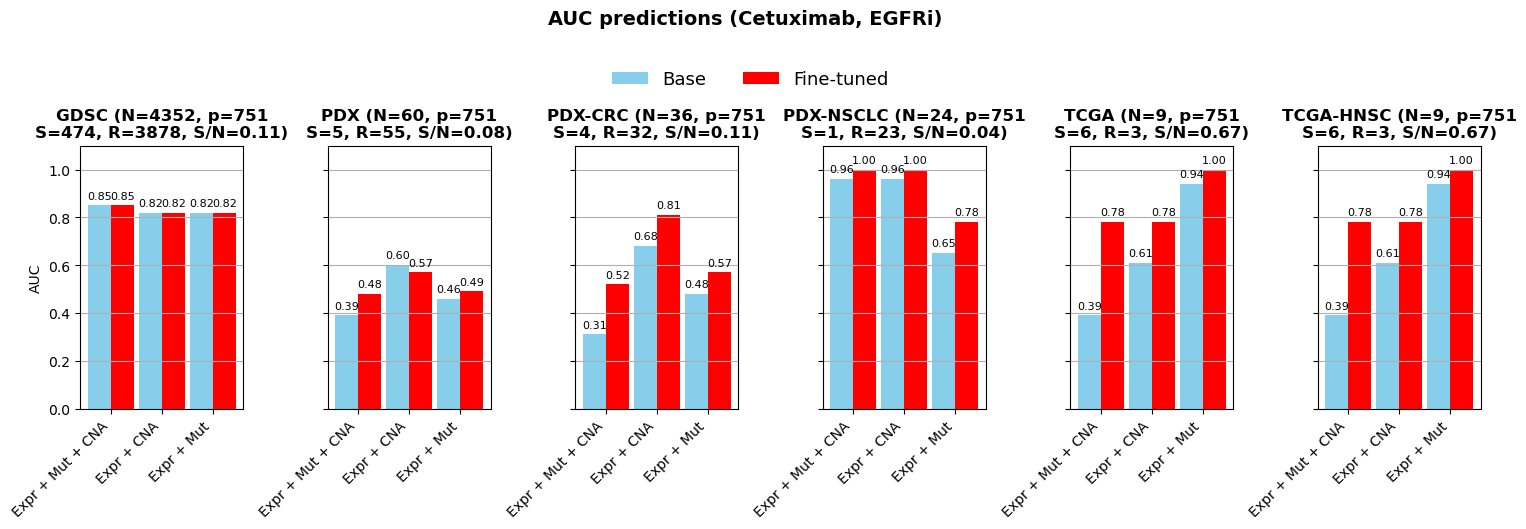

In [68]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (Cetuximab, EGFRi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUC Plot (Cetuximab, EGFRi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [69]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUCPR (PDX, N={str(len(Ytscetuximab_pdx))})",
                               f"AUCPR (PDX-CRC, N={str(len(Ytscetuximab_pdx_crc))})",
                               f"AUCPR (PDX-NSCLC, N={str(len(Ytscetuximab_pdx_nsclc))})",
                               f"AUCPR (TCGA, N={str(len(Ytscetuximab_tcga))})",
                               f"AUCPR (TCGA-HNSC, N={str(len(Ytscetuximab_tcga_hnsc))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (PDX, N={str(len(Ytscetuximab_pdx))})": f"PDX (N={str(len(Ytscetuximab_pdx))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRcetuximab["response"].value_counts()[1]) + ", R=" + str(PDXRcetuximab["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRcetuximab["response"].value_counts()[1]/sum(PDXRcetuximab["response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-CRC, N={str(len(Ytscetuximab_pdx_crc))})": f"PDX-CRC (N={str(len(Ytscetuximab_pdx_crc))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "CRC","response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-NSCLC, N={str(len(Ytscetuximab_pdx_nsclc))})": f"PDX-NSCLC (N={str(len(Ytscetuximab_pdx_nsclc))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA, N={str(len(Ytscetuximab_tcga))})": f"TCGA (N={str(len(Ytscetuximab_tcga))}, p=" + str(PDXEcetuximab.shape[1]) + "\nS=" + str(TCGARcetuximab["response"].value_counts()[1]) + ", R=" + str(TCGARcetuximab["response"].value_counts()[0]) + ", S/N=" + str(round(TCGARcetuximab["response"].value_counts()[1]/sum(TCGARcetuximab["response"].value_counts()), 2)) + ")",        
        f"AUCPR (TCGA-HNSC, N={str(len(Ytscetuximab_tcga_hnsc))})": f"TCGA-HNSC (N={str(len(Ytscetuximab_tcga_hnsc))}, p=" + str(TCGAEcetuximab.shape[1]) + "\nS=" + str(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]) + ", R=" + str(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[0]) + ", S/N=" + str(round(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()[1]/sum(TCGARcetuximab.loc[TCGARcetuximab["cohort"] == "HNSC","response"].value_counts()), 2)) + ")"
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=4352, p=751\nS=474, R=3878, S/N=0.11)","PDX (N=60, p=751\nS=5, R=55, S/N=0.08)","PDX-CRC (N=36, p=751\nS=4, R=32, S/N=0.11)","PDX-NSCLC (N=24, p=751\nS=1, R=23, S/N=0.04)","TCGA (N=9, p=751\nS=6, R=3, S/N=0.67)","TCGA-HNSC (N=9, p=751\nS=6, R=3, S/N=0.67)"
Data,,,,,,
Expr + Mut + CNA,0.4,0.13,0.1,0.5,0.62,0.62
Expr + Mut + CNA (Fine-tuned),0.4,0.17,0.14,1.0,0.91,0.91
Expr + CNA,0.4,0.16,0.19,0.5,0.79,0.79
Expr + CNA (Fine-tuned),0.39,0.28,0.28,1.0,0.92,0.92
Expr + Mut,0.38,0.12,0.12,0.11,0.98,0.98
Expr + Mut (Fine-tuned),0.38,0.14,0.15,0.17,1.0,1.0


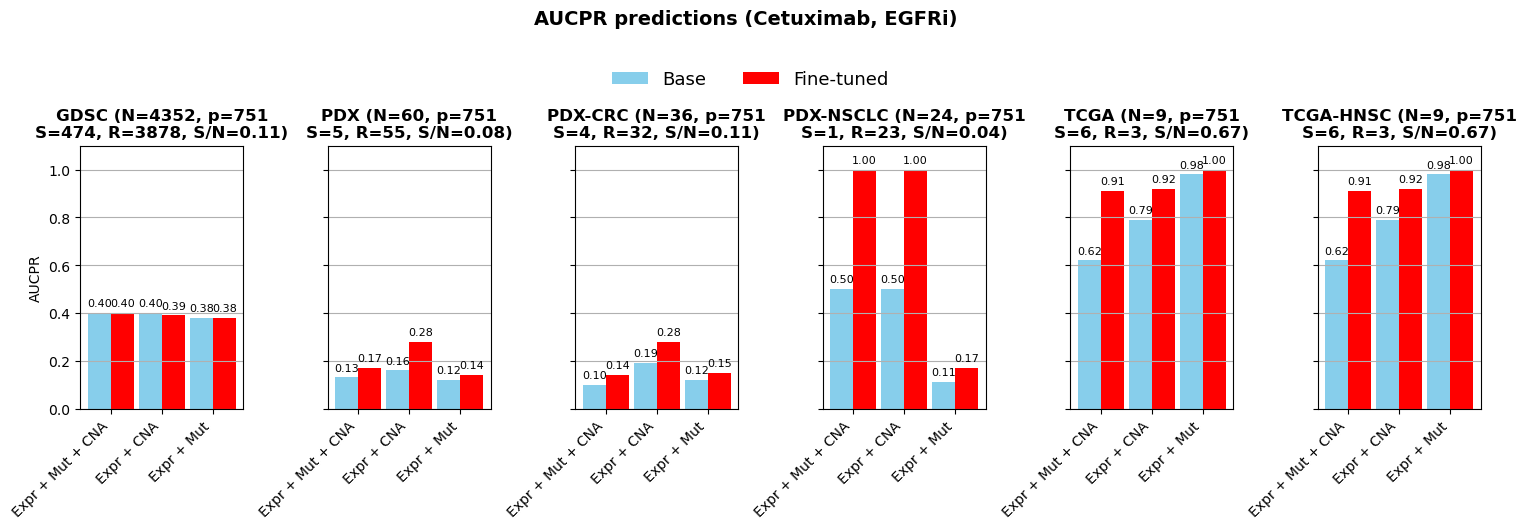

In [70]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.45
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=8)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (Cetuximab, EGFRi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (Cetuximab, EGFRi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [71]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/EGFRi/Expression_Mutation/Predictions/GDSC_PDX_TCGA_Third_Strategy


In [72]:
# save predictions

file = open('GDSC_PDX_TCGA_EGFRi_Cetuximab_Predictions_Third_Strategy (Expression and Mutation).txt', 'w')
file.write(f"GDSC Training (EM) AUC (EGFRi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EM) AUCPR (EGFRi): {round(AUCTaucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (Cetuximab): {round(AUCTcetuximab_pdx,2)}\n")
file.write(f"PDX Test (EM) AUCPR (Cetuximab): {round(AUCTcetuximab_pdx_aucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (Cetuximab, CRC): {round(AUCTcetuximab_pdx_crc,2)}\n")
file.write(f"PDX Test (EM) AUCPR (Cetuximab, CRC): {round(AUCTcetuximab_pdx_crc_aucpr,2)}\n\n")

file.write(f"PDX Test (EM) AUC (Cetuximab, NSCLC): {round(AUCTcetuximab_pdx_nsclc,2)}\n")
file.write(f"PDX Test (EM) AUCPR (Cetuximab, NSCLC): {round(AUCTcetuximab_pdx_nsclc_aucpr,2)}\n\n")

file.write(f"TCGA Test (EM) AUC (Cetuximab): {round(AUCTcetuximab_tcga,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (Cetuximab): {round(AUCTcetuximab_tcga_aucpr,2)}\n\n")

file.write(f"TCGA Test (EM) AUC (Cetuximab, HNSC): {round(AUCTcetuximab_tcga_hnsc,2)}\n")
file.write(f"TCGA Test (EM) AUCPR (Cetuximab, HNSC): {round(AUCTcetuximab_tcga_hnsc_aucpr,2)}\n")

file.close()